In [2]:
import networkx
import numpy as np
import scipy as sp
import importlib
import quasibi
import glob
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from tqdm import tqdm
importlib.reload(quasibi);

In [3]:
qbo = pd.read_fwf("../data/qbo.txt", skiprows=9, header=None, usecols=[1, 8], index_col=0)
qbo.index = [datetime(year=1953 + month//12, month=month%12 + 1, day=1) for month in range(len(qbo))]
qbo = qbo[(qbo.index.year >= 1981) & (qbo.index.year < 2021)]
qbo = qbo[(qbo.index.month >= 10) | (qbo.index.month <= 3)]
qbo = qbo.groupby(qbo.index.year - (qbo.index.month <= 3)).mean()
qbo = qbo.to_numpy().flatten()

In [33]:
pearson_files = np.sort(glob.glob("../output/dynamic/pearson*"))
rmd_files = np.sort(glob.glob("../output/dynamic/rmd_1Y*"))

D = quasibi.load_symmat("../output/distance.npy")

In [37]:
#[15:23,13:36]

M = np.zeros((len(pearson_files), 3))

last = None

for i, pearson_file in tqdm(enumerate(rmd_files), total=41):
    pearson = quasibi.load_symmat(pearson_file)
    pearson = np.abs(pearson) >= np.quantile(np.abs(pearson), 0.995)

    # average clustering
    M[i, 0] = quasibi.network_metric(pearson, quasibi.clustering_coefficient).mean()

    # average path length
    M[i, 1] = np.nanmean(quasibi.network_metric(pearson, quasibi.average_path_length))

    # closeness centrality
    M[i, 2] = quasibi.network_metric(pearson, quasibi.closeness, D=D).mean()
    
M = (M - np.mean(M, axis=0))/np.std(M, axis=0)

  0%|                                                    | 0/41 [00:00<?, ?it/s]/Users/david/Documents/UP CLEWS/3 WS2023/NDA/Report/code/quasibi.py:313: RuntimeWarning: Mean of empty slice.
  return np.array([np.trim_zeros(np.fromiter(x[1].values(), dtype="float32")).mean() for x in networkx.shortest_path_length(nx)]).reshape((25, 40))
100%|███████████████████████████████████████████| 41/41 [01:45<00:00,  2.58s/it]


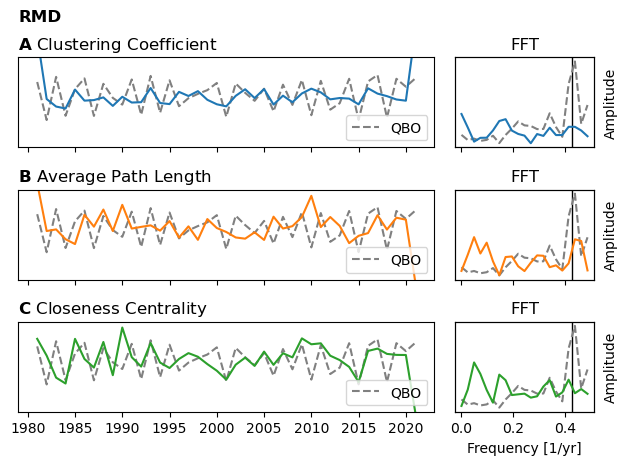

In [38]:
fig, axs = plt.subplots(3, 2, gridspec_kw={"width_ratios": [3, 1]})

time = np.arange(1981, 2022)

for i, (m, ax) in enumerate(zip(M.T, axs.T[0])):
    ax.plot(time, (qbo - np.mean(qbo))/np.std(qbo), ls="--", label="QBO", c="gray")
    ax.plot(time, m, c="C"+str(i))
    ax.set_title(r"$\bf{" + ["A", "B", "C"][i] + "}$ " + ["Clustering Coefficient", "Average Path Length", "Closeness Centrality"][i], loc="left")
    ax.set_yticks([])
    ax.set_ylim([-3.5, 2.5])
    ax.legend(loc="lower right")
    #ax.imshow(np.expand_dims(qbo, 1).T, extent=[-0.5, 39.5, -2.5, 2.5], cmap="coolwarm", vmin=-310, vmax=310)
    
    if i < 2:
        ax.set_xticklabels([])


for i, (m, ax) in enumerate(zip(M.T, axs.T[1])):
    
    ax.axvline(12/28, c="black", zorder=0, lw=1)
    ax.magnitude_spectrum((qbo - np.mean(qbo))/np.std(qbo), Fs=1, ls="--", c="gray")
    ax.magnitude_spectrum(m, Fs=1, c="C"+str(i))
    
    ax.set_title("FFT")
    
    ax.set_yticks([])
    ax.set_ylabel("")
    axt = ax.twinx()
    axt.set_yticks([])
    axt.set_ylabel("Amplitude")
    
    if i == 2:
        ax.set_xlabel("Frequency [1/yr]")
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    
    pass

plt.suptitle("RMD", horizontalalignment="left", x=0.04, y=0.96, fontweight="bold")
plt.tight_layout()
#plt.savefig("../plots/dynamic_rmd.pdf", bbox_inches="tight")